In [1]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter  # 导入SummaryWriter

import grid_env
from model import *
from render import *

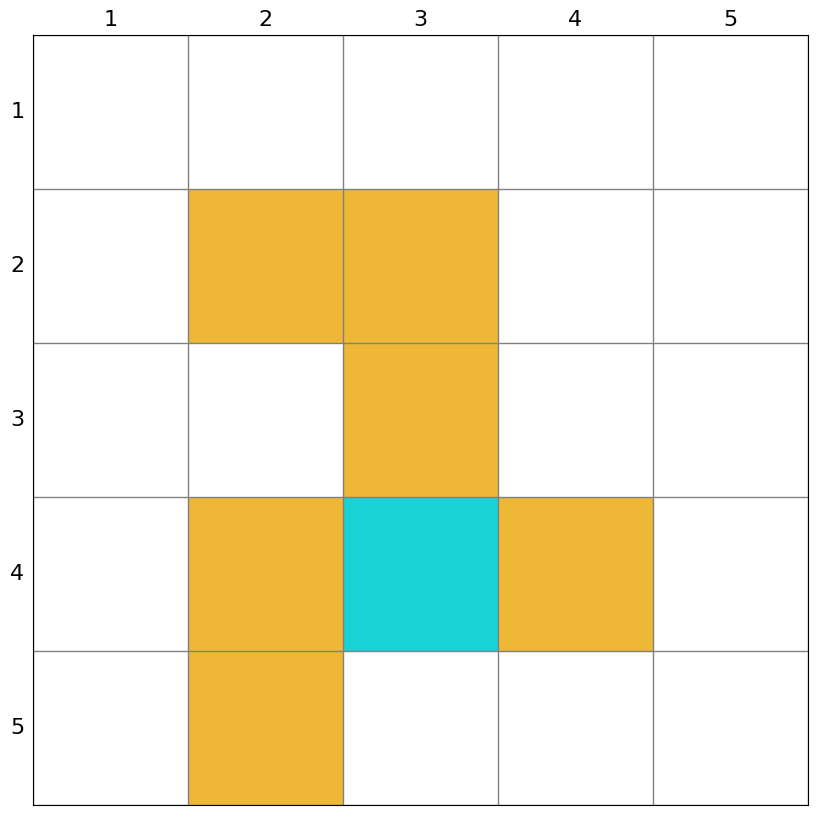

In [2]:
env = grid_env.GridEnv(size=5, target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], render_mode='')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# 模型定义
class Model(torch.nn.Module):
    def __init__(self, num_states=25):
        super().__init__()
        self.embedding = torch.nn.Embedding(num_states, 8)  # 嵌入维度改为 8
        self.fc1 = torch.nn.Linear(8, 64)
        self.fc2 = torch.nn.Linear(64, 5)

    def forward(self, state):
        if isinstance(state, int):
            state = torch.tensor([state], dtype=torch.long)
        state = self.embedding(state).squeeze(1)
        state = F.relu(self.fc1(state))
        return self.fc2(state)

# 模型和目标网络初始化
model = Model().to(device)
model_delay = Model().to(device)
model_delay.load_state_dict(model.state_dict())


<All keys matched successfully>

In [5]:

from IPython import display
import random

def obtain_episode(env, Qnet, start_state, epsilon=0.1, length=1001):
    # 初始化环境到初始状态
    env.reset()
    env.agent_loaction = env.state2pos(start_state)
    next_state = start_state
    episode = []
    reward_sum = 0
    for _ in range(length):
        state = next_state
        
        # Epsilon-greedy 动作选择
        if random.random() < epsilon:
            # 从动作空间随机选择一个动作
            action = random.choice(range(env.action_space_size))  # 对于离散动作空间，使用 env 提供的动作空间
        else:
            # 将 state 转换为 long tensor 传入 Q 网络
            state_tensor = torch.tensor([state], dtype=torch.long).to(device)  # 将 state 移动到 GPU

            # 前向传播获取动作价值
            value_combined = Qnet(state_tensor)
            # 选择价值最高的动作
            action = value_combined.argmax(dim=-1).item()  # 使用 argmax 选择动作

        # 执行选择的动作
        observation, reward, done, _, _ = env.step(action)
        reward_sum += reward
        if done:
            over = 1
        else:
            over = 0

        # 获取下一个状态
        next_state = env.pos2state(env.agent_location)

        # 添加当前步骤的记录到 episode
        episode.append([state,action,reward,next_state,over])

        if done:
            break  # 如果回合结束，退出循环

    return episode , reward_sum


In [6]:
# 经验回放池
class Pool:
    def __init__(self):
        self.max_size = 20000
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def update(self, k):
        # 获取新episode
        episode, treward = obtain_episode(env, model, 0, k)
        
        # 如果池大小超出最大限制，移除多余的数据
        extra_size = len(self.pool) + len(episode) - self.max_size
        if extra_size > 0:
            self.pool = self.pool[extra_size:]  # 移除最旧的多余条目
        
        # 更新回放池，插入新的episode
        self.pool.extend(episode)

    def sample(self, k=64):
        data = random.sample(self.pool, k)
        state = torch.LongTensor([i[0] for i in data]).reshape(-1, 1).to(device)
        action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1).to(device)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1).to(device)
        next_state = torch.LongTensor([i[3] for i in data]).reshape(-1, 1).to(device)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1).to(device)
        return state, action, reward, next_state, over

pool = Pool()

In [7]:
def train(env, epsilon=0.99, epsilon_decay=0.995, min_epsilon=0.1,gamma = 0.8):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    loss_fn = torch.nn.MSELoss()

    for epoch in range(1000):
        pool.update(0.1)

        for i in range(200):
            state, action, reward, next_state, over = pool.sample()
            state = state.long()
            value = model(state).gather(dim=1, index=action)
            with torch.no_grad():
                next_action = model(next_state).argmax(dim=1, keepdim=True)
                target = model_delay(next_state).gather(dim=1, index=next_action)

            target = reward + gamma * target * (1 - over)  # 改善 TD 目标计算方式

            loss = loss_fn(value, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 添加梯度裁剪
            optimizer.step()
            optimizer.zero_grad()

        # 更频繁地更新目标网络
        if (epoch + 1) % 2 == 0:
            model_delay.load_state_dict(model.state_dict())

        # Epsilon 衰减
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # 每 100 个 epoch 进行一次测试
        if epoch % 100 == 0:
            _, treward = obtain_episode(env, model, 0, 0.1)
            test_result = sum([treward for _ in range(20)]) / 20
            print(epoch, len(pool), test_result)

train(env)

0 1001 -1012.0
100 20000 -8727.0
200 20000 -3971.0
300 20000 -3575.0
400 20000 -3773.0
500 20000 -3773.0
600 20000 -142.0
700 20000 -246.0
800 20000 -858.0
900 20000 90.0


In [8]:
# 通过模型获取一个episode
episode, treward = obtain_episode(env, model, 0, 0)
print(episode)

state_space_size = env.size ** 2
action_space_size = env.action_space_size
policy = np.ones((state_space_size, action_space_size))

for state in range(state_space_size):
    # 将状态转换为张量，并确保其形状与模型期望的输入一致
    state_tensor = torch.LongTensor([state]).to(device)
    
    # 模型预测的Q值，假设输出是所有动作的Q值
    q_values = model(state_tensor)
    
    # 获取当前状态下最优的动作
    best_action = q_values.argmax(dim=1).item()  # 获取最优动作索引
    
    # 直接在策略表中更新对应的最优动作的概率（这里可能是设置为1，或者某个概率分布）
    # 注意：policy存储的是每个状态-动作对的值，因此应更新对应位置
    for action in range(action_space_size):
        if action == best_action:
            policy[state][action] = 1.0  # 将最优动作的概率设为1
        else:
            policy[state][action] = 0.0  # 其他动作的概率设为0

# 输出最终的策略
print(policy)


[[0, 2, -1, 5, 0], [5, 2, -1, 10, 0], [10, 2, -1, 15, 0], [15, 1, -1, 16, 0], [16, 1, -1, 17, 0], [17, 2, -1, 22, 0], [22, 1, -1, 23, 0], [23, 1, -1, 24, 0], [24, 0, -1, 19, 0], [19, 0, -1, 14, 0], [14, 3, 100, 13, 1]]
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


e:\Reinforcement_learning\scripts\render.py:153: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


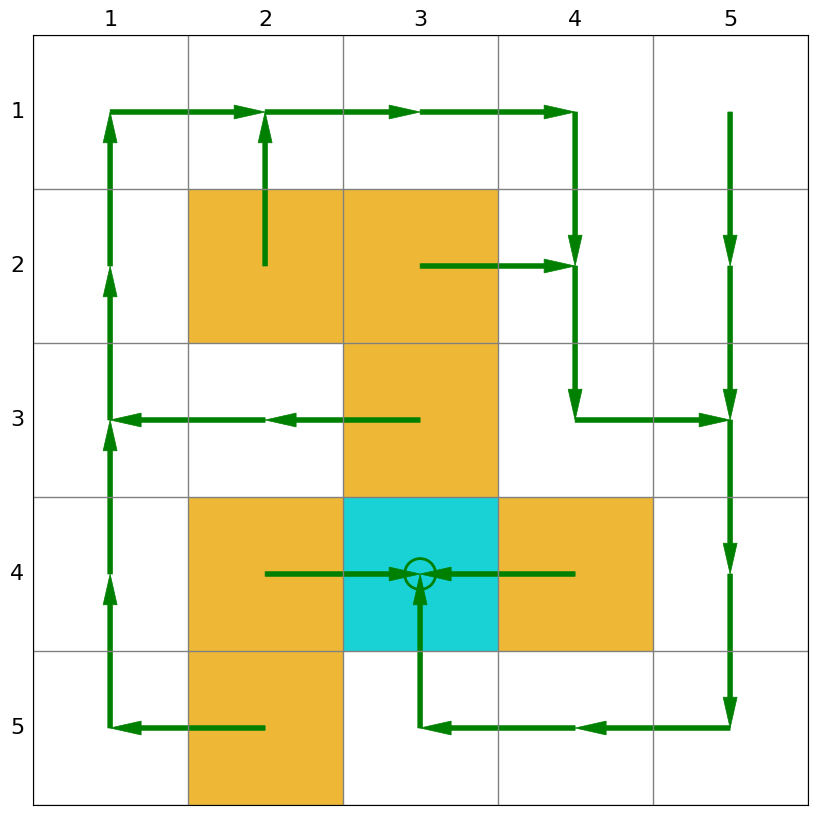

In [9]:
# 定义动作对应的方向
action_to_direction = {
    0: np.array([-1, 0]),
    1: np.array([0, 1]),
    2: np.array([1, 0]),
    3: np.array([0, -1]),
    4: np.array([0, 0]),
}
render = Render(target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], size=5)
# 绘制每个状态的最优动作
for state in range(policy.shape[0]):
    # 计算状态在网格中的位置
    row, col = env.state2pos(state)
    
    # 找出当前状态下的最优动作
    best_action = np.argmax(policy[state])
    
    # 根据最优动作绘制箭头
    render.draw_action(pos=[row, col], toward=action_to_direction[best_action])

# 显示结果
render.show_frame()